## BIG DATA

## Actividad 3 | Aprendizaje supervisado y no supervisado

## Esteban Guerrero Rivero A01795053


[1. Introducción teórica](#intro)

[2. Seleccion de los datos](#seleccion)

[3. Preparación de los datos](#preparacion)

[4. Preparación del conjunto de entrenamiento y prueba](#conjuntos)

[5. Construcón de modelos de aprendizaje no supervisado y supervisado](#modelos)

[Conclusiones](#conclusion)

<a id="intro"></a>
# Introducción teórica

# Aprendizaje supervisado

El aprendizaje supervisado es una tecnica del aprensizaje automatico, en la que se empolean datos de entrenamiento previamente etiquetados o clasificados, el objketivo del modelo es predecir de manera precisa esta etiqueta a a partir de caracteristicas de entrada, para lograr dicho cometido, se debe dividir el conjunto de datos en entrenamiento, prueba y valdación, posteriormente evaluar el modelo o ajustar los parametros con base a los resultados de las distintas metricas de evaluación como lo son _presició, rtecall, f1-score etc._

## Ejemplos de algoritmos supervisados:

Regresión Logística: _útil para clasificación binaria_

Árboles de Decisión (DecisionTreeClassifier): _divide los datos de forma jerárquica en función de sus características._

Random Forest: _ensamble de árboles para mayor precisión y menor sobreajuste._

Gradient Boosted Trees (GBTClassifier): _mejora iterativa corrigiendo errores previos._

Multilayer Perceptron: _red neuronal multicapa para clasificación compleja._

Support Vector Machines (LinearSVC): _útil para clasificación lineal binaria._

Naive Bayes: _rápido y eficiente, especialmente para texto._

## Disponibles en PySpark MLlib:

LogisticRegression

DecisionTreeClassifier

RandomForestClassifier

GBTClassifier

MultilayerPerceptronClassifier

LinearSVC

NaiveBayes

FMClassifier 

# Aprendizaje no supervisado

El aprendizaje no supervisado es la tecnica empleada cuando el conjunto de datos carece de etiquetas, el objetivo de este tipo de aprendizaje automatico, es descubir patrones o estructuras subyacentes, asi como relaciones entre los diferentes elemntos

## Ejemplos de algoritmos no supervisados:

KMeans: _agrupa datos según distancia a centros de cluster._

Gaussian Mixture Models: _permite modelar clusters como distribuciones gaussianas superpuestas._

Bisecting KMeans: _versión jerárquica del KMeans._

Power Iteration Clustering (PIC): _útil para datos representados como grafos._

LDA (Latent Dirichlet Allocation): _se usa en NLP para descubrir temas en documentos._

FPGrowth y PrefixSpan: _para minería de patrones frecuentes y reglas de asociación._

## Disponibles en PySpark MLlib:

KMeans

GaussianMixture

BisectingKMeans

PowerIterationClustering

LDA

FPGrowth, PrefixSpan (para minería de patrones)

# PySpark MLlib

Spark MLlib ofrece una API robusta para construir pipelines de machine learning, que incluyen:

Transformadores: _preparan los datos (VectorAssembler, Tokenizer, etc.)._

Estimadores: _entrenan los modelos (LogisticRegression, KMeans, etc.)._

Evaluadores: _miden el rendimiento (BinaryClassificationEvaluator, ClusteringEvaluator, etc.)._

Técnicas de muestreo: _soporta muestreo aleatorio, estratificado, por bootstrap y adaptativo para big data_

MLlib está optimizado para datos distribuidos y escalables, permitiendo entrenamiento en clústeres con grandes volúmenes de datos tanto para aprendizaje supervisado como no supervisado.

In [43]:
# Inicializar Spark
import findspark, os, re
findspark.init()
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder \
    .master('local[*]') \
    .config('spark.driver.memory', '32g') \
    .config("spark.executor.memory", "32g") \
    .appName('AmazonBooks-Sampling') \
    .getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', 'true')

In [44]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

<a id="seleccion"></a>
## Selección de los datos

In [45]:
reviews = spark.read.csv("Books_rating.csv",
                    header=True,
                    inferSchema=True,
                    sep=",",
                    quote='"',        # <- Maneja correctamente los textos entre comillas
                    escape='"'        # <- (opcional) Escapa comillas internas si las hubiera
                    )
books = spark.read.csv("books_data.csv",
                    header=True,
                    inferSchema=True,
                    sep=",",
                    quote='"',        # <- Maneja correctamente los textos entre comillas
                    escape='"'        # <- (opcional) Escapa comillas internas si las hubiera
                    )
full_data = reviews.join(books, on='Title', how='left')

In [46]:
import pandas as pd
cols = [
    "review/score",
    "price",
    "publishedDate",
    "ratingsCount",
]

# 1) Usando describe() — devuelve count, mean, stddev, min, max
desc_df = full_data.select(cols).describe().toPandas()
desc_transposed = desc_df.set_index('summary').T.drop('count', axis=1)

print(desc_transposed)

summary                      mean              stddev        min     max
review/score    4.215289333333334  1.2030537472334022        1.0     5.0
price          21.762655874939163  26.206540521370115        1.0   995.0
publishedDate  1985.0539203308863  38.030385731963555  101-01-01    20??
ratingsCount   272.09905936069714   788.8162145564311        1.0  4895.0


In [47]:
cols = [
    "publishedDate",
    "ratingsCount",
]

full_data = full_data \
    .withColumn('desc_len_chars', F.length(F.col('description'))) \
    .withColumn('desc_len_tokens', F.size(F.split(F.col('description'), r'\s+')))

stats_desc = full_data.agg(
    F.count('description').alias('count'),
    F.min('desc_len_chars').alias('min_chars'),
    F.max('desc_len_chars').alias('max_chars'),
    F.mean('desc_len_chars').alias('mean_chars'),
    F.stddev('desc_len_chars').alias('stddev_chars'),
    F.mean('desc_len_tokens').alias('mean_tokens'),
    F.stddev('desc_len_tokens').alias('stddev_tokens')
)
stats_desc.show()

+-------+---------+---------+----------------+----------------+-----------------+------------------+
|  count|min_chars|max_chars|      mean_chars|    stddev_chars|      mean_tokens|     stddev_tokens|
+-------+---------+---------+----------------+----------------+-----------------+------------------+
|2359775|        1|    26092|722.179402697291|630.200551802687|91.85404533333333|103.08612464092816|
+-------+---------+---------+----------------+----------------+-----------------+------------------+



## 2. Diseño de particiones
Las particiones se crean a partir del producto cruzado entre:
- **review_score_group**: Low (1–2), Mid (3), High (4–5)
- **categories_group**: Fiction / Non-Fiction

### Probabilidades empíricas por combinación:

In [48]:
from pyspark.sql.functions import col, when, regexp_replace, split, explode

# 1) Definir R_group
full_data = full_data.withColumn(
    "R_group",
    when(col("review/score") <= 2, "Low")
    .when(col("review/score") == 3, "Mid")
    .otherwise("High")
)

# 2) Definir C_group limpiando y usando la primera etiqueta
#    (asume formato ["Cat1","Cat2",…])
full_data = full_data.withColumn(
    "first_cat",
    split(regexp_replace(col("categories"), r"^\[|\]$", ""), r",\s*")[0]
)
full_data = full_data.withColumn(
    "C_group",
    when(col("first_cat").contains("fiction"), "Fiction").otherwise("Non‑Fiction")
).drop("first_cat")

# 3) Ver probabilidades empíricas de cada combinación
freqs = (
    full_data
    .groupBy("R_group", "C_group")
    .count()
    .withColumnRenamed("count", "N")
    .withColumn("Pr", (col("N") / full_data.count()).cast("double"))
    .orderBy("R_group", "C_group")
)
freqs.show(truncate=False)


+-------+-----------+-------+---------------------+
|R_group|C_group    |N      |Pr                   |
+-------+-----------+-------+---------------------+
|High   |Fiction    |38670  |0.01289              |
|High   |Non‑Fiction|2354289|0.784763             |
|Low    |Fiction    |3736   |0.0012453333333333333|
|Low    |Non‑Fiction|349010 |0.11633666666666667  |
|Mid    |Fiction    |3103   |0.0010343333333333333|
|Mid    |Non‑Fiction|251192 |0.08373066666666666  |
+-------+-----------+-------+---------------------+



In [49]:
from pyspark.sql.functions import col

# 1) Función auxiliar
def get_partition(df, r_group: str, c_group: str):
    return df.filter((col("R_group") == r_group) & (col("C_group") == c_group))

# 2) Generar un dict con todos los estratos
partitions = {}
for rg in ["Low", "Mid", "High"]:
    for cg in ["Fiction", "Non‑Fiction"]:
        key = f"{rg}×{cg}"
        partitions[key] = get_partition(full_data, rg, cg)

# 3) Ver conteos de cada partición
for key, df_part in partitions.items():
    print(f"{key}: {df_part.count():,} rows")

Low×Fiction: 3,736 rows
Low×Non‑Fiction: 349,010 rows
Mid×Fiction: 3,103 rows
Mid×Non‑Fiction: 251,192 rows
High×Fiction: 38,670 rows
High×Non‑Fiction: 2,354,289 rows


## 3. Técnica de muestreo
Se usará **muestreo aleatorio simple estratificado** (SRS) dentro de cada estrato (R_group x C_group) por estas razones:.

**Control de heterogeneidad**: cada combinación de sentimiento (Low/Mid/High) y género (Fiction/Non‑Fiction) se trata como una subpoblación homogénea.

**Minimización de sesgos**: al muestrear por estrato, evitamos que los grupos grandes dominen la muestra.

**Asignación tipo Neyman**: definimos fracciones mayores en estratos pequeños para garantizar un tamaño de muestra mínimo, y menores en estratos muy grandes para eficiencia.

### Fórmula de tamaño de muestra de Cochran

$$
n_0 = \frac{Z^2 \cdot p \cdot (1 - p)}{E^2}
$$

Donde:

- **n₀** = tamaño de muestra inicial para poblaciones grandes (antes de cualquier ajuste para poblaciones finitas)  
- **Z** = valor z (por ejemplo, 1.96 para un 95 % de confianza)  
- **p** = proporción poblacional estimada (usar 0.5 si se desconoce)  
- **E** = margen de error  

In [50]:
#Definición del tamaño de muestra
import math

Z = 2.56 # 99% de confianza
p = 0.5 # probabilidad de que el usuario le guste el libro
E = 0.01 # margen de error

n0 = (Z**2 * p * (1-p)) / (E**2)
print("Tamaño de muestra necesario:", n0)

N = full_data.count() # población total

n = n0 / (1 + ((n0 - 1) / N))
n = math.ceil(n)
print(f"Tamaño de muestra ajustado (población finita): {n}")

Tamaño de muestra necesario: 16384.0
Tamaño de muestra ajustado (población finita): 16296


### Fórmula para muestreo estratificado

El muestreo estratificado se utiliza cuando una población puede dividirse en subgrupos distintos, o estratos, como grupos de edad, género o nivel educativo. El tamaño de muestra para cada estrato puede determinarse mediante el uso de la asignación proporcional:

$$
n_h = \frac{N_h}{N} \cdot n
$$

Donde:

- **nₕ** = tamaño de muestra para el estrato h  
- **Nₕ** = tamaño de la población en el estrato h  
- **N** = tamaño total de la población  
- **n** = tamaño total de la muestra  

In [51]:
from pyspark.sql.functions import concat_ws, col
fraction = n / N


# 1) Definición de frecuencias para obtener como mínimo 50 muestras por estrato
fractions = {
    "Low×Fiction":      50/3756,
    "Low×Non‑Fiction":  fraction,
    "Mid×Fiction":      50/3103,
    "Mid×Non‑Fiction":  fraction,
    "High×Fiction":     fraction,
    "High×Non‑Fiction": fraction,
}

# 2) Creo la columna compuesta
full2 = full_data.withColumn(
    "stratum",
    concat_ws("×", col("R_group"), col("C_group"))
)

# 3) Muestreo estratificado usando esa columna
sample_df = full2.stat.sampleBy("stratum", fractions, seed=42)

# 4) Veo el conteo por estrato para validar
sample_df.groupBy("R_group", "C_group") \
         .count() \
         .orderBy("R_group", "C_group") \
         .show(truncate=False)


+-------+-----------+-----+
|R_group|C_group    |count|
+-------+-----------+-----+
|High   |Fiction    |225  |
|High   |Non‑Fiction|12936|
|Low    |Fiction    |58   |
|Low    |Non‑Fiction|1861 |
|Mid    |Fiction    |56   |
|Mid    |Non‑Fiction|1414 |
+-------+-----------+-----+



In [52]:
# Estadísticas exploratorias por grupo
sample_df.groupBy('R_group', 'C_group') \
    .agg(F.count('*').alias('N'),
         F.round(F.avg('review/score'),2).alias('MeanScore')) \
    .orderBy('R_group','C_group') \
    .show()

+-------+-----------+-----+---------+
|R_group|    C_group|    N|MeanScore|
+-------+-----------+-----+---------+
|   High|    Fiction|  225|      4.8|
|   High|Non‑Fiction|12936|     4.75|
|    Low|    Fiction|   58|      1.6|
|    Low|Non‑Fiction| 1861|     1.43|
|    Mid|    Fiction|   56|      3.0|
|    Mid|Non‑Fiction| 1414|      3.0|
+-------+-----------+-----+---------+



In [53]:
# 3) Verificación de probabilidades de cada combinación en la muestra
#    (deberían ser similares a las de la población)
#    (asume que la muestra es representativa)
freqs_Sample = (
    sample_df
    .groupBy("R_group", "C_group")
    .count()
    .withColumnRenamed("count", "N")
    .withColumn("Pr", (col("N") / sample_df.count()).cast("double"))
    .orderBy("R_group", "C_group")
)
freqs_Sample.show(truncate=False)

+-------+-----------+-----+---------------------+
|R_group|C_group    |N    |Pr                   |
+-------+-----------+-----+---------------------+
|High   |Fiction    |225  |0.013595166163141994 |
|High   |Non‑Fiction|12936|0.7816314199395771   |
|Low    |Fiction    |58   |0.0035045317220543807|
|Low    |Non‑Fiction|1861 |0.11244712990936556  |
|Mid    |Fiction    |56   |0.0033836858006042296|
|Mid    |Non‑Fiction|1414 |0.0854380664652568   |
+-------+-----------+-----+---------------------+



<a id="preparacion"></a>
## Preparación de los datos

In [56]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import NumericType

# 1. Seleccionar columnas numéricas reales
features_cols = ["review/score", "Price", "ratingsCount", "desc_len_chars", "desc_len_tokens"]

# 2. Asegurarse de que no hay valores nulos
sample_df = sample_df.select(*features_cols, "R_group", "C_group", "stratum").dropna()

# 3. Armar el vector de características
assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
sample_df = assembler.transform(sample_df)

# 4. Verifica que se creó la columna 'features'
sample_df.select("features").show(5, truncate=False)

+----------------------------+
|features                    |
+----------------------------+
|[5.0,10.2,1.0,1174.0,199.0] |
|[5.0,6.52,39.0,228.0,32.0]  |
|[5.0,6.48,52.0,1078.0,189.0]|
|[2.0,10.95,2.0,185.0,30.0]  |
|[4.0,8.99,1.0,1734.0,273.0] |
+----------------------------+
only showing top 5 rows



<a id="conjuntos"></a>
## Preparación del conjunto de entrenamiento y prueba

In [65]:
# Dividir el dataset en entrenamiento y prueba
train_df, test_df = sample_df.randomSplit([0.7, 0.3], seed=42)
print(f"Entrenamiento: {train_df.count()} filas")
print(f"Prueba: {test_df.count()} filas")

Entrenamiento: 668 filas
Prueba: 307 filas


<a id="modelos"></a>
## Construcción de modelos de aprendizaje no supervisado y supervisado

In [66]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Entrenar modelo con los datos de entrenamiento
rf = RandomForestClassifier(labelCol="review/score", featuresCol="features", numTrees=100, maxDepth=5)
model_rf = rf.fit(train_df)

# Predecir en el conjunto de prueba
predictions = model_rf.transform(test_df)

# Evaluación multiclase
evaluator = MulticlassClassificationEvaluator(labelCol="review/score", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print("🔍 Evaluación del modelo en el conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

🔍 Evaluación del modelo en el conjunto de prueba:
Accuracy: 1.0000
F1 Score: 1.0000
Precision: 1.0000
Recall: 1.0000


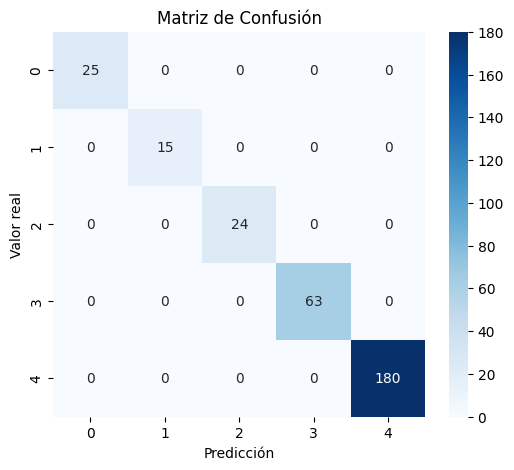

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convertir predicciones a pandas
pdf_pred = predictions.select("review/score", "prediction").toPandas()

# Calcular matriz de confusión
cm = confusion_matrix(pdf_pred["review/score"], pdf_pred["prediction"])

# Visualizar
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión")
plt.show()

In [68]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol="features", k=3, seed=42)
kmeans_model = kmeans.fit(sample_df)
clusters = kmeans_model.transform(sample_df)

evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
silhouette = evaluator.evaluate(clusters)

print(f"🔍 Resultados del modelo no supervisado (KMeans):")
print(f"Silhouette Score: {silhouette:.4f}")
print("Centroides:")
for i, center in enumerate(kmeans_model.clusterCenters()):
    print(f"  Centro {i}: {center}")

🔍 Resultados del modelo no supervisado (KMeans):
Silhouette Score: 0.7299
Centroides:
  Centro 0: [  4.26903553  17.78778342  21.68866328 394.86463621  63.69881557]
  Centro 1: [   4.2027027    17.91716216   20.54054054 1440.07297297  234.0972973 ]
  Centro 2: [   4.           13.28857143 3177.71428571  400.78571429   60.42857143]


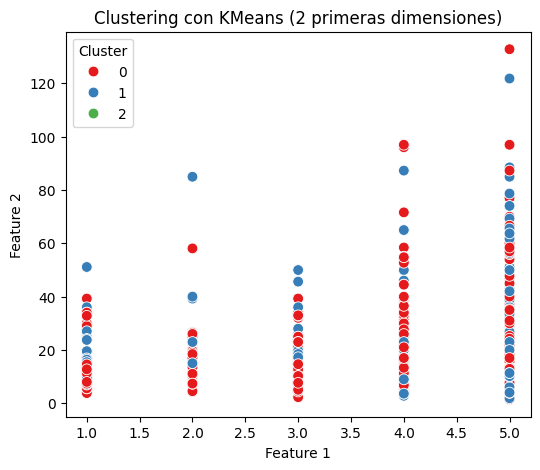

In [69]:
# Visualización del resultado de clustering (usando 2 primeras dimensiones del vector)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pandas_clusters = clusters.select("prediction", "features").toPandas()
pandas_clusters["x"] = pandas_clusters["features"].apply(lambda v: v[0])
pandas_clusters["y"] = pandas_clusters["features"].apply(lambda v: v[1])

plt.figure(figsize=(6, 5))
sns.scatterplot(data=pandas_clusters, x="x", y="y", hue="prediction", palette="Set1", s=60)
plt.title("Clustering con KMeans (2 primeras dimensiones)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

<a id="conclusion"></a>
## Conclusión

Efectivamente, aunque el archivo seleccionado es de aproximadamente 2GB al descomprimirlo, las operaciones con el tienen un costo computacional considerable, tomando varios segundos e incluso minutos para ejecutarse, por otro lado, aunque habia realizado la actividad inicial de la instalacion del entorno Pyspark con Python 3.12, tuve problemas de crasheo al tratar de implementar los modelos de ML de la libreria de pyspark, por lo que tuve que crear un entorno adicional con Python 3.10.

Con este ejercicio se implementaron 2 técnicas de aprendizaje automatico con ayuda de la líbreria de ML de pyspark, cabe aclarar que en RandomForestClasifier existe un error, el cual por falta de tiempo ya no me fue posible verificar, voy a identificar el error y seguir trabajando este archivo.

